The UPOS field contains a part-of-speech tag from the universal POS tag set, while the XPOS optionally contains a language-specific (or even treebank-specific) part-of-speech / morphological tag

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import pickle_load
from process_conllu import ConlluDataset

In [10]:
def merge_word_hidden_pos(viterbi_pos, true_pos, obs_seqs):
    merged_pos = []
    for seq_idx, (pred_hidden_seq, true_hidden_seq, obs_seq) in enumerate(zip(
        viterbi_pos, true_pos, obs_seqs)):
        for hidden_state, pos, obs_state in zip(pred_hidden_seq, true_hidden_seq, obs_seq):
            merged_pos.append((seq_idx, hidden_state, pos, obs_state))
    return pd.DataFrame(merged_pos, columns=["sentence", "hidden state", "pos", "token"])

In [11]:
hmm_upos_df = pd.read_csv("results/eval_hmm_upos.csv")
hmm_xpos_df = pd.read_csv("results/eval_hmm_xpos.csv")
bert_upos_df = pd.read_csv("results/eval_bert_upos.csv")
bert_xpos_df = pd.read_csv("results/eval_bert_xpos.csv")
dataset: ConlluDataset = pickle_load("checkpoints/dataset.pkl")
viterbi_upos: list[list[int]] = pickle_load("checkpoints/viterbi_upos.pkl")
viterbi_xpos: list[list[int]] = pickle_load("checkpoints/viterbi_xpos.pkl")

In [12]:
merged_pos = []
for seq_idx, (pred_hidden_seq, true_hidden_seq, obs_seq) in enumerate(zip(
    viterbi_upos, dataset.upos, dataset.sequences)):
    for hidden_state, pos, obs_state in zip(pred_hidden_seq, true_hidden_seq, obs_seq):
        merged_pos.append((seq_idx, hidden_state, pos, obs_state))

In [13]:
sentence_len = [len(seq) for seq in dataset.sequences]
# dropna later so pd will track which idx are dropped
hmm_upos_df["sentence length"] = sentence_len
hmm_xpos_df["sentence length"] = sentence_len
bert_upos_df["sentence length"] = sentence_len
bert_xpos_df["sentence length"] = sentence_len


# divide by zero entropy in some rows
hmm_upos_df["normalised voi"] = hmm_upos_df["normalised voi"].astype(float)
hmm_xpos_df["normalised voi"] = hmm_xpos_df["normalised voi"].astype(float)
bert_upos_df["normalised voi"] = bert_upos_df["normalised voi"].astype(float)
bert_xpos_df["normalised voi"] = hmm_upos_df["normalised voi"].astype(float)
hmm_upos_df.dropna(inplace=True)
hmm_xpos_df.dropna(inplace=True)
bert_upos_df.dropna(inplace=True)
bert_xpos_df.dropna(inplace=True)

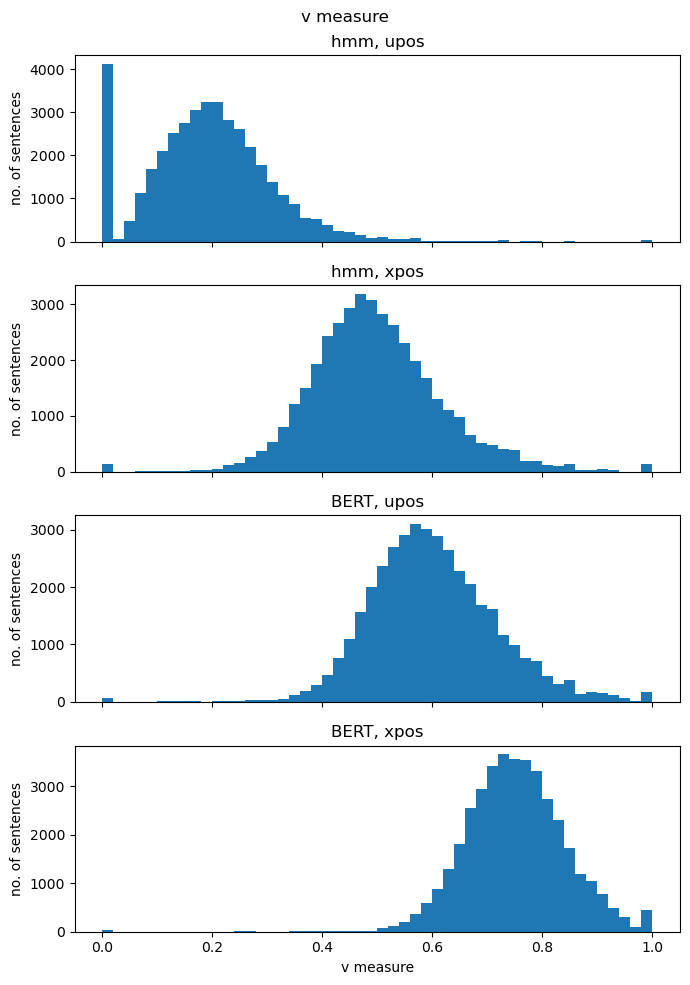

In [14]:
fig, ax = plt.subplots(4, 1, sharex=True)
bins=50

fig.suptitle("v measure")
for i in range(4):
  ax[i].set_ylabel("no. of sentences")

ax[0].set_title("hmm, upos")
ax[0].hist(hmm_upos_df["v measure"], bins=bins)

ax[1].set_title("hmm, xpos")
ax[1].hist(hmm_xpos_df["v measure"], bins=bins)

ax[2].set_title("BERT, upos")
ax[2].hist(bert_upos_df["v measure"], bins=bins)

ax[3].set_title("BERT, xpos")
ax[3].hist(bert_xpos_df["v measure"], bins=bins)
ax[3].set_xlabel("v measure")

fig.set_size_inches(7, 10)
fig.tight_layout()
plt.show()

I initially hypothesised forward backward algorithm to perform better on UPOS than XPOS because the transition matrix is sparser given the same dataset size. It is with great surprise that it managed to capture the more fine-grained XPOS better.

It is likewise surprising that v measure for the more fine-grained XPOS performed better. However, it comes with no surprise that BERT captured POS better than forward backward algorithm, by a huge margin of about 0.2 in both cases.

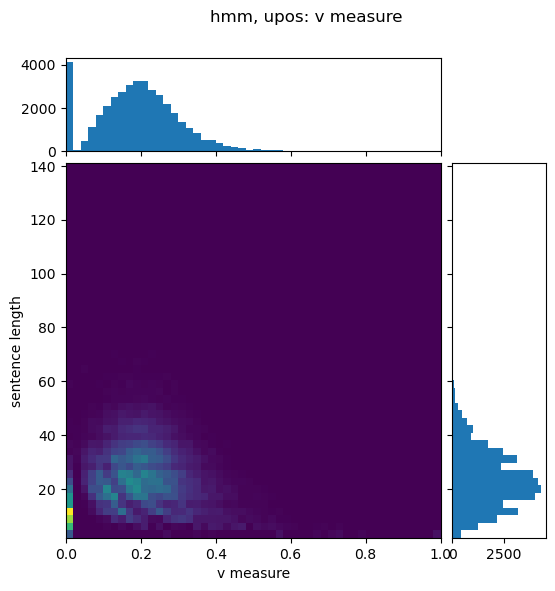

In [15]:
x = hmm_upos_df["v measure"]
y = hmm_upos_df["sentence length"]
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with 2 rows, 2 columns, ratio of 1 to 4 between
# size of marginal & main axes in both directions.
# left, right, bottom, top set the bounds (out of 1) of whole fig
# 0 is bottom left, 1 is top right
# wspace, hspace are padding between main & marginal axes
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                    left=0.1, right=0.9, bottom=0.1, top=0.9,
                    wspace=0.05, hspace=0.05)
# create axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

fig.suptitle("hmm, upos: v measure")
ax.set_xlabel("v measure")
ax.set_ylabel("sentence length")

ax.hist2d(x, y, bins=50)
ax_histx.hist(x, bins=50)
ax_histy.hist(y, bins=50, orientation='horizontal')
plt.show()

Given the large no. of zeros in v measure for hmm, upos, it was imperative to find out if sentence lengths played any role. I hypothesised that on extremely short and long sentences it would not perform well. For extremely short sentences, the first token is difficult to predict accurately. For extremely long sentences, probabilities are very close to zero and HMM will completely fail. Moreover, Viterbi algorithm is greedy and may enter into a local minima and the errors cascade.

It was clear that for sentences up to length 22, with the distribution centred 6-8, there was a large number of sentences that completely went off track. This effect completely disappeared for longer sentences.

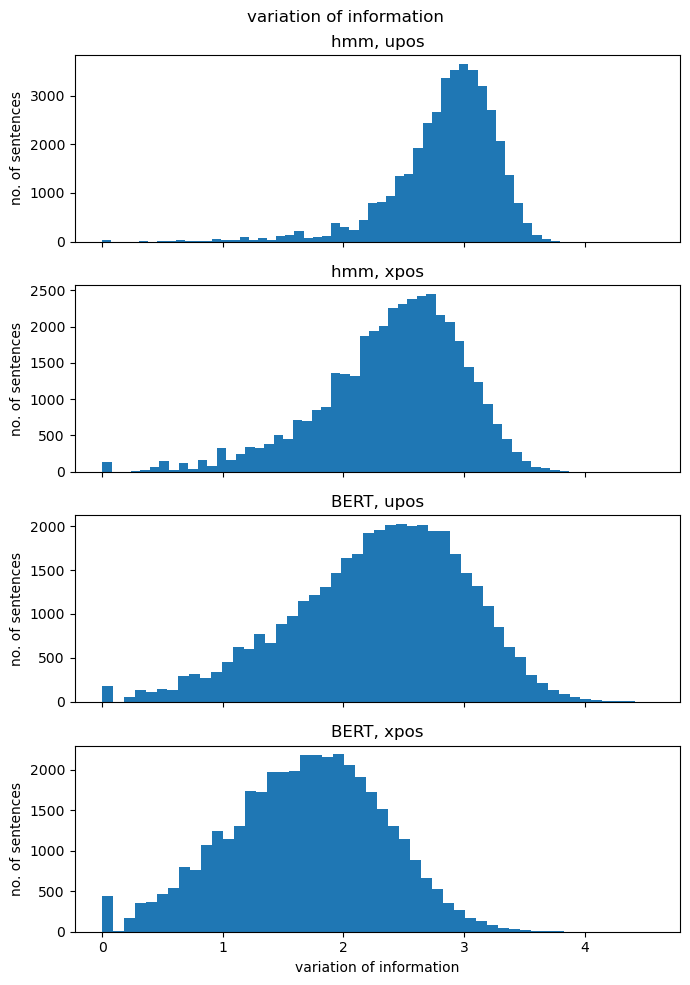

In [16]:
fig, ax = plt.subplots(4, 1, sharex=True)
bins=50

fig.suptitle("variation of information")
for i in range(4):
  ax[i].set_ylabel("no. of sentences")

ax[0].set_title("hmm, upos")
ax[0].hist(hmm_upos_df["voi"], bins=bins)

ax[1].set_title("hmm, xpos")
ax[1].hist(hmm_xpos_df["voi"], bins=bins)

ax[2].set_title("BERT, upos")
ax[2].hist(bert_upos_df["voi"], bins=bins)

ax[3].set_title("BERT, xpos")
ax[3].hist(bert_xpos_df["voi"], bins=bins)
ax[3].set_xlabel("variation of information")

fig.set_size_inches(7, 10)
fig.tight_layout()
plt.show()

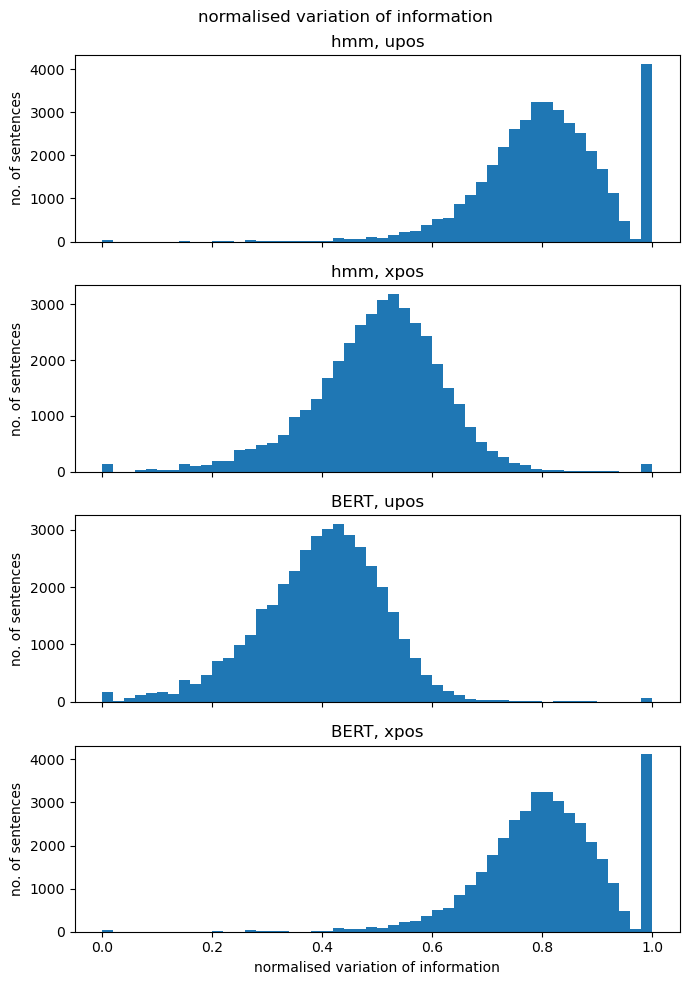

In [17]:
fig, ax = plt.subplots(4, 1, sharex=True)
bins=50

fig.suptitle("normalised variation of information")
for i in range(4):
  ax[i].set_ylabel("no. of sentences")

ax[0].set_title("hmm, upos")
ax[0].hist(hmm_upos_df["normalised voi"], bins=bins)

ax[1].set_title("hmm, xpos")
ax[1].hist(hmm_xpos_df["normalised voi"], bins=bins)

ax[2].set_title("BERT, upos")
ax[2].hist(bert_upos_df["normalised voi"], bins=bins)

ax[3].set_title("BERT, xpos")
ax[3].hist(bert_xpos_df["normalised voi"], bins=bins)
ax[3].set_xlabel("normalised variation of information")

fig.set_size_inches(7, 10)
fig.tight_layout()
plt.show()

In [18]:
viterbi_upos_df = merge_word_hidden_pos(viterbi_upos, dataset.upos, dataset.sequences)
viterbi_xpos_df = merge_word_hidden_pos(viterbi_xpos, dataset.xpos, dataset.sequences)

In [19]:
viterbi_upos_df["hidden state"].groupby(viterbi_upos_df["hidden state"]).size()

hidden state
0        384
1      48723
11    806505
16     94089
Name: hidden state, dtype: int64

In [20]:
upos_hidden_state_to_token = viterbi_upos_df[["hidden state", "token"]]\
  .groupby("token")\
  .agg(count=("token", "count"),
       hidden_states=("hidden state", frozenset))\
  .reset_index()

In [32]:
upos_hidden_state_to_token.sort_values("count", ascending=False).head(20)

,token,count,hidden_states
19,",",48723,(1)
30807,the,47975,(11)
27,.,39020,(11)
108,[NUM],23927,(11)
21245,of,23005,(11)
31175,to,22352,(11)
279,a,20149,(11)
15156,in,16931,(11)
1383,and,16668,(11)
15,'s,9326,(11)


In [22]:
set([len(s) for s in upos_hidden_state_to_token["hidden_states"]])

{1}

In [23]:
viterbi_xpos_df["hidden state"].groupby(viterbi_xpos_df["hidden state"]).size()

hidden state
6     631570
11     23927
24     16931
29     48723
30     39020
40     95441
44     94089
Name: hidden state, dtype: int64

In [24]:
xpos_hidden_state_to_token = viterbi_xpos_df[["hidden state", "token"]]\
  .groupby("token")\
  .agg(count=("token", "count"),
       hidden_states=("hidden state", frozenset))\
  .reset_index()

In [31]:
xpos_hidden_state_to_token.sort_values("count", ascending=False).head(20)

,token,count,hidden_states
19,",",48723,(29)
30807,the,47975,(40)
27,.,39020,(30)
108,[NUM],23927,(11)
21245,of,23005,(6)
31175,to,22352,(6)
279,a,20149,(6)
15156,in,16931,(24)
1383,and,16668,(40)
15,'s,9326,(6)


In [26]:
set([len(s) for s in xpos_hidden_state_to_token["hidden_states"]])

{1, 2}

In [28]:
xpos_hidden_state_to_token[np.array([len(s) for s in xpos_hidden_state_to_token["hidden_states"]]) == 2]["hidden states"]

,token,count,hidden_states
324,abc,50,"(40, 6)"
756,aeroflot,22,"(40, 6)"
979,akzo,30,"(40, 6)"
1360,analysts,534,"(40, 6)"
1688,apple,61,"(40, 6)"
...,...,...,...
32667,usx,49,"(40, 6)"
33268,walter,39,"(40, 6)"
33420,wcrs,34,"(40, 6)"
33734,why,136,"(40, 6)"


In [30]:
s = xpos_hidden_state_to_token[np.array([len(s) for s in xpos_hidden_state_to_token["hidden_states"]]) == 2]["hidden_states"]
s.groupby(s).size()

hidden_states
(40, 6)    72
Name: hidden_states, dtype: int64